
# How does the shape / size of our network affect its ability to learn?

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="6"
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.layers import Dense, Conv2D, Flatten, Dropout
import ptetaphi_nn
import tools
with open("filepath.txt", 'r') as f:
    filename = f.read()
    
s_table = tools.open_file(filename, sort_by="tag")

Using TensorFlow backend.


sorting data by tag


In [2]:
# filter by realistic situation where we have 3 tags and 3 or 4 jets.
# ignore the case where there may be >4 since those are pretty rare
nb4 = (s_table.nbjets == 3) | (s_table.nbjets == 4) # 3 or 4 b-jets exist
nt3 = s_table.nbtags==3  # 3 b tags
nb4nt3 = nb4 & nt3
events = s_table[nb4nt3]
print(len(events))

vents = s_table[nt3]

# and ensure that the 3 tags are actually correct
# this results in very little event loss
events = events[events.truth[:,0] == 1]
events = events[events.truth[:,1] == 1]
events = events[events.truth[:,2] == 1]
print(len(events))

cutoff = 10  # not many events have >10 jets
# "pad" = ensure all events have same length, cut off ends if needed
events = tools.pad(events, cutoff)

# then ensure require pt >= 40 and |eta| <= 2.5
pt_filter = events.resolved_lv.pt <= 40
events.resolved_lv.pt[pt_filter] = 0
events.resolved_lv.eta[pt_filter] = 0
events.resolved_lv.phi[pt_filter] = 0

eta_filter = (events.resolved_lv.eta >= -2.5) & (events.resolved_lv.eta >= 2.5)
events.resolved_lv.pt[eta_filter] = 0
events.resolved_lv.eta[eta_filter] = 0
events.resolved_lv.phi[eta_filter] = 0
print(events.resolved_lv.pt[0])
print(events.tag[0])
print(len(events))

308955
303925
[65.84481  55.581104 52.658108 56.41042   0.        0.        0.
  0.        0.        0.      ]
[1 1 1 0 0 0 0 0 0 0]
303925


In [7]:
import importlib
importlib.reload(ptetaphi_nn)
nn = ptetaphi_nn.PtEtaPhiNN(events, load=("architecture_same_filters.json", "weights_same_filters.h5"), njets=10)

scaling
DATA FOR .csv file:
pt_mean,pt_mean,pt_var,eta_mean,eta_var,phi_mean,phi_var
256.31926975623963,28002.162204528897,-0.0011182470524250965,1.0668815076637497,0.0059166731456395194,3.2939911869626477
165.19714898705237,14678.807516109595,-0.005035429247770503,1.1332807109908833,-0.0037738410750480966,3.2528703871575653
71.28253170922466,2601.1974988115267,-0.0005726554464193643,0.9482846550071378,-6.080123821136251e-05,2.71479103549647
149.69398241112594,22323.41626698641,-0.15032644723394134,1.587565877256741,0.009579089603642784,2.762661295595709
46.46214265503773,4728.972587169259,-0.14575822743754402,1.1539118216296498,0.0017263933883823487,1.5835106188182952
14.289153115103941,1081.441464258451,-0.07777478134246826,0.5651223530065548,0.00010363542291488327,0.6676842272938854
3.9062325319938287,248.18075517923177,-0.029618675253727154,0.20130375279499416,0.0007399833097378556,0.22064506774057785
0.922864866715626,52.74821213303246,-0.008164926272285546,0.054006339564912256,0.

100%|██████████| 1/1 [00:00<00:00, 2531.26it/s]

using different data than when this model was created
scaling
DATA FOR .csv file:
pt_mean,pt_mean,pt_var,eta_mean,eta_var,phi_mean,phi_var
236.20181274414062,0.0,-1.2858734130859375,0.0,-1.4166144132614136,0.0
67.19342803955078,0.0,-1.4730103015899658,0.0,1.6427026987075806,0.0
42.153621673583984,0.0,0.06353621184825897,0.0,-2.7302451133728027,0.0
332.3666687011719,0.0,0.30277934670448303,0.0,1.8544366359710693,0.0
124.79906463623047,0.0,-1.692347526550293,0.0,-0.9179929494857788,0.0
0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0
[[0 0 0 1 0 0 0 0 0 0]]
[[1 1 1 0 1 0 0 0 0 0]]



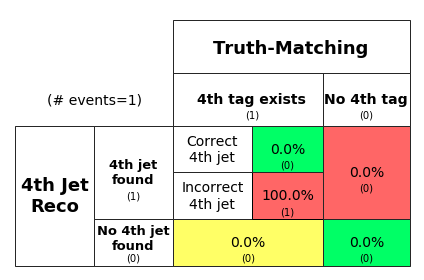

In [32]:
import awkward
import uproot_methods as urm
importlib.reload(tools)
one_event = awkward.Table()

index = 10

lv = urm.TLorentzVectorArray.from_ptetaphie(events.resolved_lv.pt[index].reshape(1, -1),
                                            events.resolved_lv.eta[index].reshape(1, -1),
                                            events.resolved_lv.phi[index].reshape(1, -1),
                                            events.resolved_lv.E[index].reshape(1, -1))

one_event.resolved_lv = lv
one_event.truth = events.truth[index].reshape(1, -1)
one_event.tag = events.tag[index].reshape(1, -1)
nn.evaluate(one_event)